# Modelling

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, RatingSVD, LogisticSVD
from RecData import RecData

## Data Preprocessing

In [3]:
# recs = pd.read_csv('data/recommendations.csv')
# recs = pd.read_csv('data/pruned.csv')
recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (10267907, 3)


,app_id,is_recommended,user_id
68896,291550,True,0
3122844,493520,True,0
9243712,552990,True,1
8542315,1407200,True,1
201969,394360,True,5


In [4]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [5]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

print("Creating splits...")
train_data, val = rec_data.leave_k_out_split(k=1, create_val=False)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 1 / 2586404
Done user 10001 / 2586404
Done user 20001 / 2586404
Done user 30001 / 2586404
Done user 40001 / 2586404
Done user 50001 / 2586404
Done user 60001 / 2586404
Done user 70001 / 2586404
Done user 80001 / 2586404
Done user 90001 / 2586404
Done user 100001 / 2586404
Done user 110001 / 2586404
Done user 120001 / 2586404
Done user 130001 / 2586404
Done user 140001 / 2586404
Done user 150001 / 2586404
Done user 160001 / 2586404
Done user 170001 / 2586404
Done user 180001 / 2586404
Done user 190001 / 2586404
Done user 200001 / 2586404
Done user 210001 / 2586404
Done user 220001 / 2586404
Done user 230001 / 2586404
Done user 240001 / 2586404
Done user 250001 / 2586404
Done user 260001 / 2586404
Done user 270001 / 2586404
Done user 280001 / 2586404
Done user 290001 / 2586404
Done user 300001 / 2586404
Done user 310001 / 2586404
Done user 320001 / 2586404
Done user 330001 / 2586404
Done user 340001 / 2586404
Do

In [6]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [7]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [8]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

Epoch 0/Training loss: 0.3849008052116189/Validation loss: 0.3604221025715285/Time: 44.76 seconds
Epoch 1/Training loss: 0.3797320456289584/Validation loss: 0.3571666761641172/Time: 40.95 seconds
Epoch 2/Training loss: 0.3761635482283195/Validation loss: 0.35594422637642237/Time: 41.15 seconds
Epoch 3/Training loss: 0.37311058196721475/Validation loss: 0.35495172299452/Time: 41.15 seconds
Epoch 4/Training loss: 0.3703595660580059/Validation loss: 0.35398852253806845/Time: 40.88 seconds
Epoch 5/Training loss: 0.3678390878936521/Validation loss: 0.3533061619242304/Time: 40.91 seconds
Epoch 6/Training loss: 0.36536800297881367/Validation loss: 0.35254271500044226/Time: 42.65 seconds
Epoch 7/Training loss: 0.3631282145521661/Validation loss: 0.3519279643449978/Time: 41.35 seconds
Epoch 8/Training loss: 0.36090462390284983/Validation loss: 0.3513142132427469/Time: 41.14 seconds
Epoch 9/Training loss: 0.35878805117680423/Validation loss: 0.350777938247923/Time: 41.41 seconds
Epoch 10/Trainin

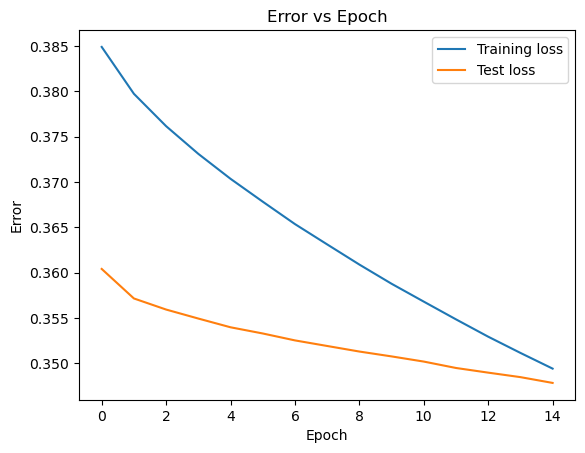

Validation rmse 0.3239615889166525


In [9]:
# for pruned, epoch: 30, lr:0.01, reg:0.02, k=50
# for pruned, epoch: 60, lr:0.01, reg:0.02, k=80

EPOCHS = 80

random.seed(42)
np.random.seed(42)

# # Fit and predict with svd
# svd_predictor = RatingSVD(
#     train_data.get_num_users(), train_data.get_num_items(), 2, k=10, 
#     learning_rate=0.001, C=0.02)
# svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
    learning_rate=0.01, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training loss')
plt.plot(range(len(val_errors)), val_errors, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Validation rmse", rmse)

We can now continue to train if we believe the model is still underfitting.

In [22]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training loss: 0.26055184857243413/Validation loss: 0.33215441910028165/Time: 44.19 seconds
Epoch 1/Training loss: 0.2581570649997859/Validation loss: 0.33202368043776737/Time: 42.78 seconds
Epoch 2/Training loss: 0.2557909336251658/Validation loss: 0.33196996961358505/Time: 42.38 seconds
Epoch 3/Training loss: 0.2533850241725807/Validation loss: 0.33177209013049774/Time: 42.48 seconds
Epoch 4/Training loss: 0.25096388039230744/Validation loss: 0.3316669577551104/Time: 42.41 seconds
Epoch 5/Training loss: 0.2485737576702542/Validation loss: 0.331544816333337/Time: 42.42 seconds
Epoch 6/Training loss: 0.24619801961460253/Validation loss: 0.3314634192147364/Time: 43.48 seconds
Epoch 7/Training loss: 0.24378503357788725/Validation loss: 0.33133048452665775/Time: 42.88 seconds
Epoch 8/Training loss: 0.24137541072430388/Validation loss: 0.33119491046044364/Time: 47.26 seconds
Epoch 9/Training loss: 0.23907285892763863/Validation loss: 0.33121503068976077/Time: 57.65 seconds


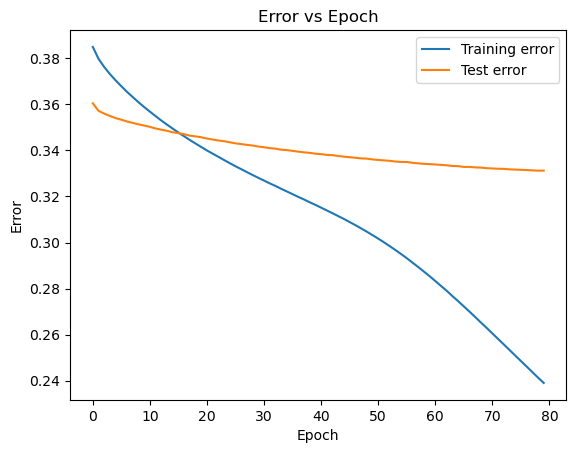

Test rmse 0.31582896856524795


In [23]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [ ]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 0


## Preparing for Production

In [ ]:
svd_predictor.prep_for_item_knn()


## Saving the model

In [24]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [2]:
with open('saved_models/2023-7-8-12-15-13_0-37.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

In [11]:
train_data.search_title('call')

[('Call of Duty: World at War', 612),
 ("Forest Legends: The Call of Love Collector's Edition", 1377),
 ('Call of Duty® 4: Modern Warfare®', 530),
 ('Call of Duty®: Modern Warfare® 2 (2009)', 649),
 ('Call of Duty®: WWII', 867),
 ('theHunter: Call of the Wild™', 69),
 ('Call of Duty®: Black Ops III', 235),
 ('Call of Duty®: Black Ops', 517),
 ('S.T.A.L.K.E.R.: Call of Pripyat', 719),
 ('The Callisto Protocol™', 118),
 ('Call of Duty®: Infinite Warfare', 778),
 ('Call of Duty®: Black Ops II', 848),
 ('Call to Arms - Gates of Hell: Ostfront', 1085),
 ('Call to Arms', 1055),
 ('Call of Juarez: Gunslinger', 510),
 ('Call of Duty®: Modern Warfare® II', 28),
 ('Call of the Wild: The Angler™', 605),
 ('Call of Duty®: Modern Warfare® 3', 573),
 ('Call of Duty®: Advanced Warfare - Gold Edition', 1120)]

In [14]:
top = svd_predictor.items_knn([(573, 1)], n=1)
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.31919805788322353, 'Disney Princess: My Fairytale Adventure'),
 (0.31482037342062313, 'The Last Wizard'),
 (0.3146955018206333, 'RuneScape ®'),
 (0.30499141758494425, 'Get In The Car Loser!'),
 (0.3028254144699418, 'Kingdom Two Crowns'),
 (0.29852658924847986, 'PokerStars VR'),
 (0.2977899220999424, 'Sable'),
 (0.2946157731845478, 'Rust'),
 (0.29185394044662594, 'OVR Toolkit'),
 (0.288641998677187, 'Lil Gator Game')]


In [13]:
svd_predictor._user_features[0, :]
svd_predictor._item_features[1066, :]
np.max(svd_predictor._user_biases)
np.max(svd_predictor._item_biases)
# np.max(svd_predictor._item_features)

0.9472438167803995

In [26]:
j = 1

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 10)
print("Predicted top n:")
pprint([index for r, index in top_n])
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[402, 819, 1008, 369, 2013, 1820, 1566, 901, 437, 1665]
[(0.9983270563864977, 'Portal 2'),
 (0.9973533935754233, 'A Hat in Time'),
 (0.9970579636288595, 'Lil Gator Game'),
 (0.9966652461261196, 'Terraria'),
 (0.9966148110408145, 'Thief™ II: The Metal Age'),
 (0.9964096640258538, 'Dogs Organized Neatly'),
 (0.9954031355165291, 'DOOM (1993)'),
 (0.9949438052100903, 'Sizeable'),
 (0.9945179877727448, 'OMORI'),
 (0.9945048413637746, 'Mafia II (Classic)')]
True top n:
['Vampire Survivors',
 'Call of Duty®: Modern Warfare® II',
 'Borderlands 3',
 'Left 4 Dead 2']


In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [46]:
train_data.search_title('GunPoint')

[('Gunpoint', 1066)]

In [21]:
prefs = [(147, 1), (325, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(147, 'The Elder Scrolls V: Skyrim Special Edition', 1),
 (325, 'Slay the Spire', 1)]


In [22]:
epochs = 1

start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=epochs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 6.88 seconds
Completed partial fit in 7.875029563903809 seconds


In [28]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 10)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9987608146858127, 'Portal 2'),
 (0.9969967969293526, 'A Hat in Time'),
 (0.9952055750129399, 'Terraria'),
 (0.9939231456186107, 'Thief™ II: The Metal Age'),
 (0.9938464256065681, 'Lil Gator Game'),
 (0.9936272229187082, 'Mafia II (Classic)'),
 (0.9934598331074666, 'POSTAL 2'),
 (0.9909451404418662, 'Monolith'),
 (0.9907963903985133, 'Choice of Robots'),
 (0.9907266718244505, 'Bastion')]
